## Power Consumption Forcasting

In this project, we predict the power consumption Mocorro. The electricity consumption became really crucial to this country due to the rapidly increased oil product import price after 2015. So we need to study the impact on energy consumption. The dataset is exhaustive in its demonstration of energy consumption of the Tétouan city in Morocco. The distribution network is powered by 3 Zone stations, namely: Quads, Smir and Boussafou. And we also do a prediction for the power consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError


In [3]:
df = pd.read_csv('powerconsumption.csv')

In [4]:
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [5]:
# Here we use date column as the index
df.index = pd.to_datetime(df.pop("Datetime"), format="%m/%d/%Y %H:%M")

In [6]:
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature             52416 non-null  float64
 1   Humidity                52416 non-null  float64
 2   WindSpeed               52416 non-null  float64
 3   GeneralDiffuseFlows     52416 non-null  float64
 4   DiffuseFlows            52416 non-null  float64
 5   PowerConsumption_Zone1  52416 non-null  float64
 6   PowerConsumption_Zone2  52416 non-null  float64
 7   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [8]:
# There's no missing value in our data
df.isna().sum()

Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [9]:
# We get hourly records to make our data tiny.
df = df[0::6]
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 01:00:00,5.641,77.7,0.080,0.048,0.096,25998.98734,16993.31307,17945.06024
2017-01-01 02:00:00,5.059,78.6,0.081,0.070,0.096,23003.54430,15169.60486,16117.59036
2017-01-01 03:00:00,5.169,77.9,0.083,0.066,0.108,21107.84810,13535.56231,15140.24096
2017-01-01 04:00:00,4.753,75.7,0.083,0.044,0.134,20524.55696,12820.66869,14585.06024


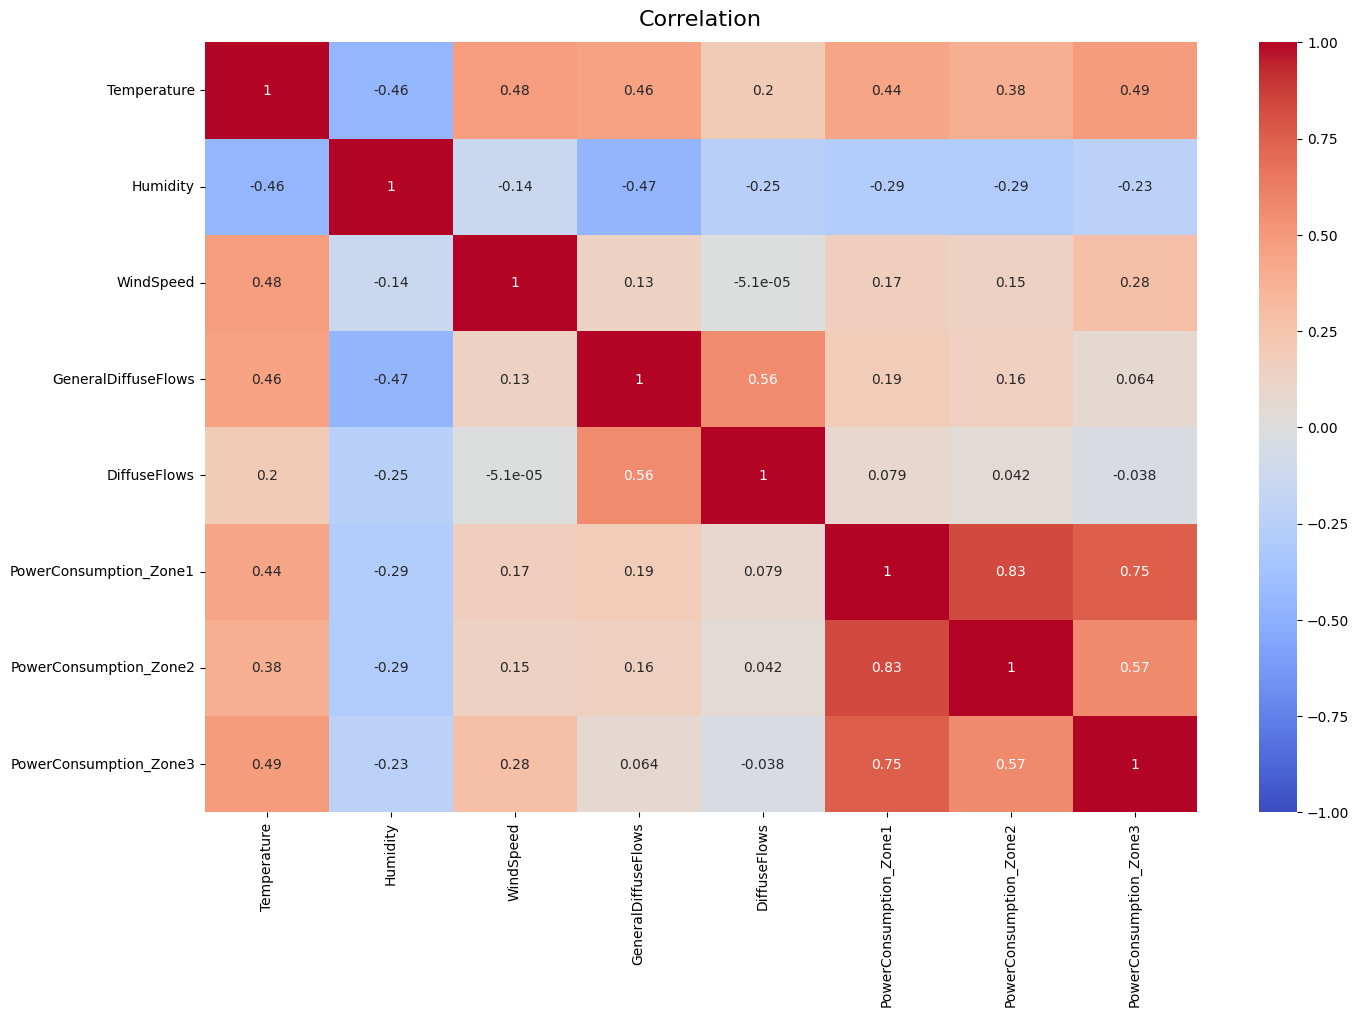

In [10]:
plt.figure(figsize = (16, 10))
heatmap = sns.heatmap(df.corr(numeric_only = True), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')
heatmap.set_title('Correlation', fontdict = {'fontsize':16}, pad = 12);

From this heatmap, we can see the correlation of each feature effect on the power consumption. For example, we can see the temperature has positive effect on the power consumption. This is because we use air conditioners or fans with increasing temperature. And the humidity has negative correlation with the power consumption. This is because we use the Humidifier when the wether is dry (the humidity is low.).

In [11]:
# Now we will do the prediction for power consumption
# We first define some function for plotting figures and predicting
def plot_features(df, features=[], n_samples=None):
    for column in features:
        if n_samples:
            plt.plot(df[column][:n_samples])
        else:
            plt.plot(df[column])
        plt.title(column)
        plt.show()

def plot_feature(df, feature, n_samples=None):
    if n_samples:
        plt.plot(df[feature][:n_samples])
    else:
        plt.plot(df[feature])
    plt.title(feature)
    plt.show()

def plot_splits(df, train_df, val_df, target):
    if df is not None:
        plt.plot(df[target], label="Original")
    if train_df is not None:
        plt.plot(train_df[target], label="Train")
    if val_df is not None:
        plt.plot(val_df[target], label="test")
    plt.legend(loc="upper left")
    plt.title("Train and test splits")
    plt.show()

def generate_windows(df, inputs, outputs, window_size=5):
    X = []
    Y = []
    for i in range(len(df)-window_size):
        row = [[df[input][j] for input in inputs] for j in range(i, i+window_size)]
        X.append(row)
        label = [df[output][i+window_size] for output in outputs]
        Y.append(label)
    return np.array(X), np.array(Y)

def plot_loss(model, plot_test=True):
    history = model.history.history

    loss = history["loss"]
    if plot_test:
        val_loss = history["val_loss"]

    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(loss, label="Training loss")
    if plot_test:
        plt.plot(val_loss, label="test loss")
    plt.legend(loc="upper right")
    plt.show()

def plot_predictions(model, X, y, n_samples=None):
    predictions = model.predict(X, verbose=0).flatten()

    plt.title("Predictions")
    plt.xlabel("Time step")
    plt.ylabel("Signal")
    if not n_samples:
        plt.plot(predictions, label="Predictions")
        plt.plot(y, label="Ground truth")
    else:
        plt.plot(predictions[:n_samples], label="Predictions")
        plt.plot(y[:n_samples], label="Ground truth")
    plt.legend()
    plt.show()

def plot_predictions_multivariate(model, X, y, n_features, n_samples=None, label_names=None):
    predictions = model.predict(X, verbose=0)

    if label_names:
        assert n_features == len(label_names)

    plt.figure()
    plt.title("Predictions")

    for i in range(n_features):
        if not n_samples:
            plt.plot(predictions[:, i], label="Predictions")
            plt.plot(y[:, i], label="Ground truth")
        else:
            plt.plot(predictions[:, i][:n_samples], label="Predictions")
            plt.plot(y[:, i][:n_samples], label="Ground truth")
        if label_names:
            plt.title(label_names[i])
        plt.legend()
        plt.show()

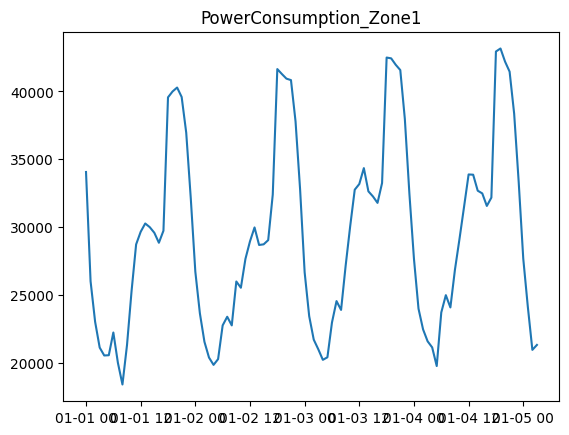

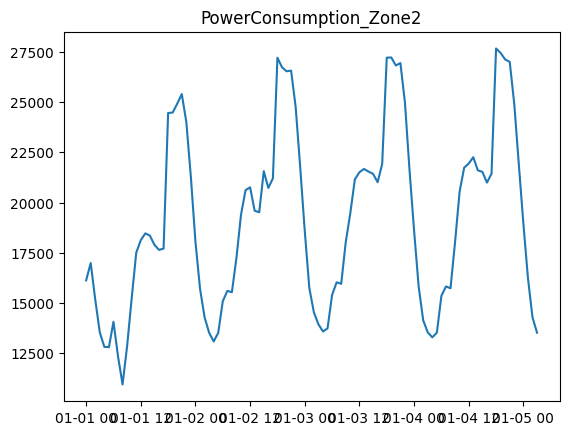

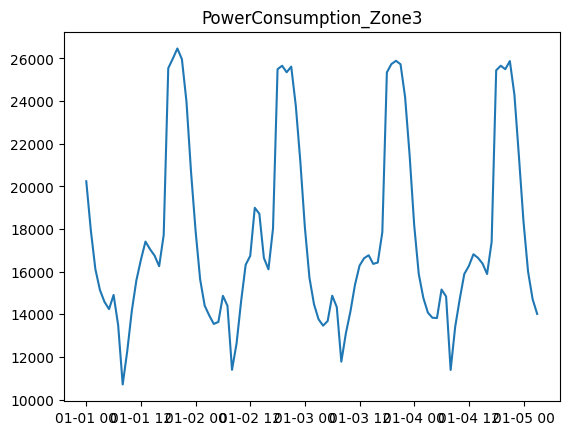

In [12]:
# We choose 100 samples
plot_features(df, ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"], 100)

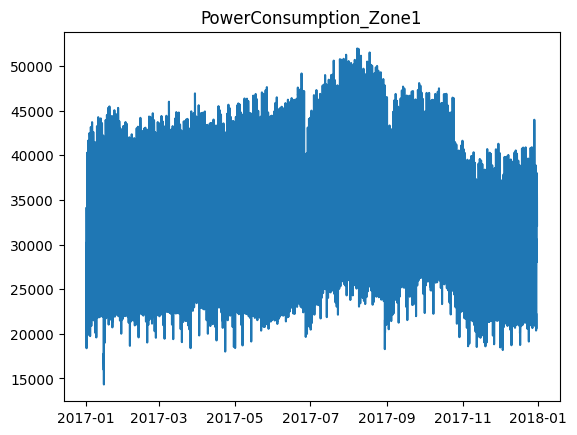

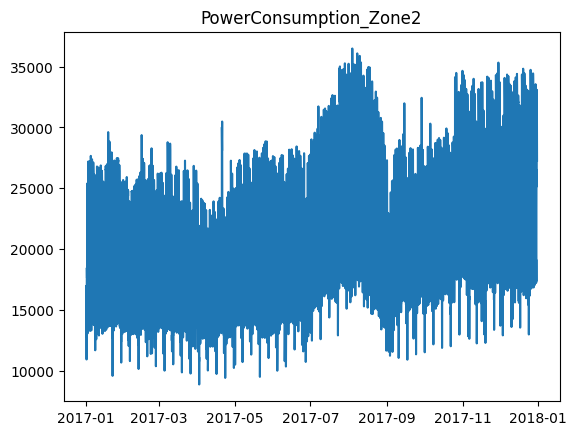

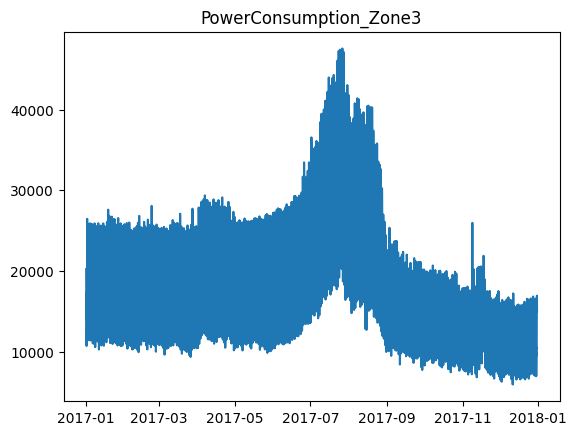

In [13]:
# We plot all data
plot_features(df, ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"])

### Univariate forecaster for PowerConsumption_Zone1

#### Baseline model
Baseline model is to make predict based on the previous value.

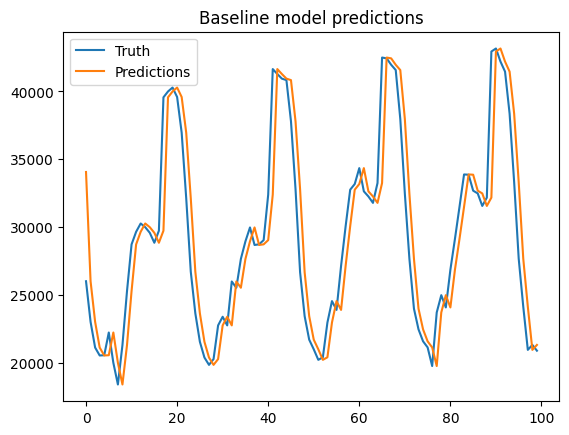

In [14]:
# Here we use the sample number 100 because we can see the seasonal change of the data.
baseline_truth = df["PowerConsumption_Zone1"][1:].to_numpy()
baseline_predictions = df["PowerConsumption_Zone1"][:-1].to_numpy()

n_samples = 100
plt.plot(baseline_truth[:n_samples], label="Truth")
plt.plot(baseline_predictions[:n_samples], label="Predictions")
plt.title("Baseline model predictions")
plt.legend(loc="upper left")
plt.show()

In [15]:
# Calculate RMSE (Root Mean Squared Error)

baseline_mse = np.mean(np.power(baseline_truth - baseline_predictions, 2))
baseline_rmse = np.sqrt(baseline_mse)

print(f"Baseline MSE: {baseline_mse}")
print(f"Baseline RMSE: {baseline_rmse}")

Baseline MSE: 8824112.850433981
Baseline RMSE: 2970.5408346686604


The MSE and RMSE is high. Although the trend of our predicted value looks good, but it has a movement. This is due to we predict our value based on the previous value. We try to find a better models.

#### Neutral Network Model

In [16]:
from datetime import datetime
split_date = datetime.strptime('2017-11-01','%Y-%m-%d')

train_df1 = df[df.index < split_date]
test_df1 = df[df.index >= split_date]

print(f"Train dataset: {train_df1.shape}")
print(f"Test dataset: {test_df1.shape}")

Train dataset: (7296, 8)
Test dataset: (1440, 8)


In [17]:
# Here, we gererate our test and train data only based on the power consumption in Zone1.
X_train1, y_train1 = generate_windows(
    df = train_df1,
    inputs = ["PowerConsumption_Zone1"],
    outputs = ["PowerConsumption_Zone1"],
    window_size = 5,
)

print(f"X_train1: {X_train1.shape}")
print(f"y_train1: {y_train1.shape}")

X_train1: (7291, 5, 1)
y_train1: (7291, 1)


In [18]:
X_test1, y_test1 = generate_windows(
    df = test_df1,
    inputs = ["PowerConsumption_Zone1"],
    outputs = ["PowerConsumption_Zone1"],
    window_size = 5
)

print(f"X_test1: {X_test1.shape}")
print(f"y_test1: {y_test1.shape}")

X_test1: (1435, 5, 1)
y_test1: (1435, 1)


In [19]:
model1 = tf.keras.Sequential([
    Input(shape=(5, 1)),
    Conv1D(64, 2),
    Flatten(),
    Dense(16, activation="relu"),
    Dense(1, activation="linear"),
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)

model1.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=[RootMeanSquaredError()]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 16)                4112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


In [20]:
epochs = 100
batch_size = 32
callbacks = [
    ModelCheckpoint("model1/", save_best_only=True),
    EarlyStopping(patience=20),
]

model1.fit(
    X_train1,
    y_train1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    validation_data=(X_test1, y_test1),
)

Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 25947020.0000 - root_mean_squared_error: 5093.8218

228/228 [==============================] - 4s 10ms/step - loss: 25947020.0000 - root_mean_squared_error: 5093.8218 - val_loss: 4812514.5000 - val_root_mean_squared_error: 2193.7444
Epoch 2/100
228/228 [==============================] - 1s 3ms/step - loss: 7583237.0000 - root_mean_squared_error: 2753.7678 - val_loss: 5190392.5000 - val_root_mean_squared_error: 2278.2434
Epoch 3/100
228/228 [==============================] - 1s 3ms/step - loss: 7164837.0000 - root_mean_squared_error: 2676.7214 - val_loss: 5605021.5000 - val_root_mean_squared_error: 2367.4927
Epoch 4/100
228/228 [==============================] - 1s 3ms/step - loss: 7204738.0000 - root_mean_squared_error: 2684.1643 - val_loss: 5976380.0000 - val_root_mean_squared_error: 2444.6636
Epoch 5/100
228/228 [==============================] - 1s 3ms/step - loss: 7610923.0000 - root_mean_squared_error: 2758.7900 - val_loss: 6235510.0000 - val_root_mean_squared_error: 2497.1003
Epoch 6/100
219/228 [===========================>..] - 

228/228 [==============================] - 1s 6ms/step - loss: 7256120.5000 - root_mean_squared_error: 2693.7188 - val_loss: 4728492.0000 - val_root_mean_squared_error: 2174.5095
Epoch 7/100
228/228 [==============================] - 1s 3ms/step - loss: 7304883.5000 - root_mean_squared_error: 2702.7549 - val_loss: 4846837.5000 - val_root_mean_squared_error: 2201.5535
Epoch 8/100
228/228 [==============================] - 1s 3ms/step - loss: 7367613.5000 - root_mean_squared_error: 2714.3347 - val_loss: 8090995.0000 - val_root_mean_squared_error: 2844.4675
Epoch 9/100
228/228 [==============================] - 1s 3ms/step - loss: 8451297.0000 - root_mean_squared_error: 2907.1116 - val_loss: 6774899.5000 - val_root_mean_squared_error: 2602.8638
Epoch 10/100
228/228 [==============================] - 1s 3ms/step - loss: 7516696.0000 - root_mean_squared_error: 2741.6594 - val_loss: 5378142.0000 - val_root_mean_squared_error: 2319.0820
Epoch 11/100
228/228 [==============================] - 

228/228 [==============================] - 2s 7ms/step - loss: 7171158.0000 - root_mean_squared_error: 2677.9019 - val_loss: 4676739.0000 - val_root_mean_squared_error: 2162.5769
Epoch 21/100
228/228 [==============================] - 1s 2ms/step - loss: 7003158.0000 - root_mean_squared_error: 2646.3481 - val_loss: 5610286.0000 - val_root_mean_squared_error: 2368.6042
Epoch 22/100
228/228 [==============================] - 1s 3ms/step - loss: 7004141.0000 - root_mean_squared_error: 2646.5337 - val_loss: 5172356.0000 - val_root_mean_squared_error: 2274.2815
Epoch 23/100
228/228 [==============================] - 1s 3ms/step - loss: 7394568.5000 - root_mean_squared_error: 2719.2957 - val_loss: 5290845.5000 - val_root_mean_squared_error: 2300.1838
Epoch 24/100
228/228 [==============================] - 1s 2ms/step - loss: 7007248.5000 - root_mean_squared_error: 2647.1208 - val_loss: 4802271.0000 - val_root_mean_squared_error: 2191.4084
Epoch 25/100
228/228 [==============================]

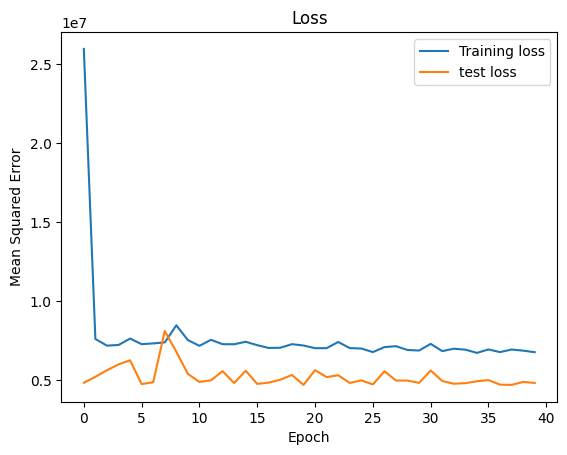

In [21]:
plot_loss(model1)

In [23]:
# load best model
model1 = tf.keras.models.load_model("model1")

model1_train_rmse = model1.evaluate(X_train1, y_train1, verbose=0)[1]
model1_val_rmse = model1.evaluate(X_test1, y_test1, verbose=0)[1]

print(f"Model 1 Training RMSE: {model1_train_rmse}")
print(f"Model 1 Val RMSE: {model1_val_rmse}")

Model 1 Training RMSE: 2557.8603515625
Model 1 Val RMSE: 2162.576904296875


Here, we found neutral network model is better than the baseline model.

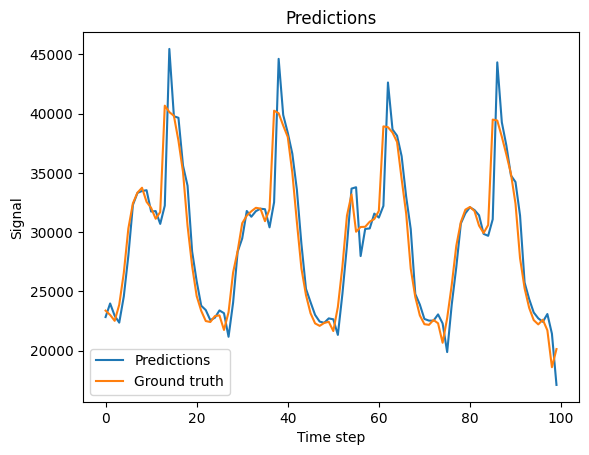

In [24]:
plot_predictions(model1, X_test1, y_test1, n_samples=100)

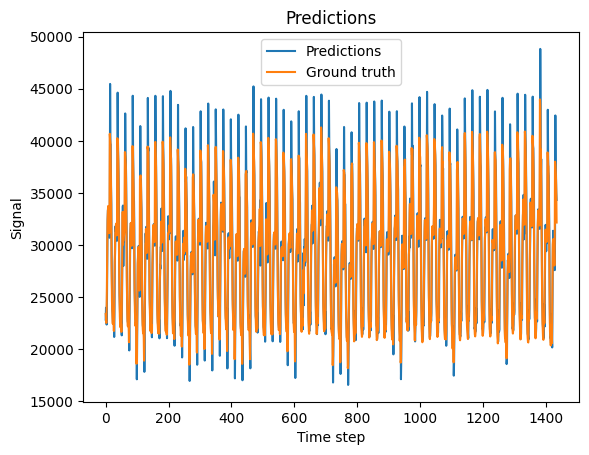

In [25]:
plot_predictions(model1, X_test1, y_test1)

Here, we can see that for the univariate forecaster method, neutral network do a better job. But it still cannot well capture the sharply changed signal.

### Multivariate forecaster for PowerConsumption_Zone1

In [26]:
from datetime import datetime
split_date = datetime.strptime('2017-11-01','%Y-%m-%d')

train_df2 = df[df.index < split_date]
test_df2 = df[df.index >= split_date]

print(f"Train dataset: {train_df2.shape}")
print(f"Test dataset: {test_df2.shape}")

Train dataset: (7296, 8)
Test dataset: (1440, 8)


In [27]:
X_train2, y_train2 = generate_windows(
    df = train_df2,
    inputs = ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"],
    outputs = ["PowerConsumption_Zone1"],
    window_size = 5,
)

print(f"X_train2: {X_train2.shape}")
print(f"y_train2: {y_train2.shape}")

X_train2: (7291, 5, 3)
y_train2: (7291, 1)


In [28]:
X_test2, y_test2 = generate_windows(
    df = test_df2,
    inputs = ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"],
    outputs = ["PowerConsumption_Zone1"],
    window_size = 5,
)

print(f"X_test2: {X_test2.shape}")
print(f"y_test2: {y_test2.shape}")

X_test2: (1435, 5, 3)
y_test2: (1435, 1)


In [29]:
model2 = tf.keras.Sequential([
    Input(shape=(5, 3)),
    Conv1D(64, 2),
    Flatten(),
    Dense(16, activation="relu"),
    Dense(1, activation="linear"),
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)

model2.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=[RootMeanSquaredError()]
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             448       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                4112      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________


In [32]:
epochs = 200
batch_size = 32
callbacks = [
    ModelCheckpoint("model2/", save_best_only=True),
    EarlyStopping(patience=20),
]

model2.fit(
    X_train2,
    y_train2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    validation_data=(X_test2, y_test2),
)

Epoch 1/200
220/228 [===========================>..] - ETA: 0s - loss: 17522016.0000 - root_mean_squared_error: 4185.9307

228/228 [==============================] - 3s 9ms/step - loss: 17186056.0000 - root_mean_squared_error: 4145.6069 - val_loss: 5706473.0000 - val_root_mean_squared_error: 2388.8225
Epoch 2/200
228/228 [==============================] - 1s 3ms/step - loss: 9346119.0000 - root_mean_squared_error: 3057.1423 - val_loss: 8443001.0000 - val_root_mean_squared_error: 2905.6843
Epoch 3/200
228/228 [==============================] - 1s 3ms/step - loss: 7717923.5000 - root_mean_squared_error: 2778.1150 - val_loss: 7118356.5000 - val_root_mean_squared_error: 2668.0249
Epoch 4/200
228/228 [==============================] - 1s 3ms/step - loss: 6991214.5000 - root_mean_squared_error: 2644.0906 - val_loss: 7891028.0000 - val_root_mean_squared_error: 2809.0974
Epoch 5/200
225/228 [============================>.] - ETA: 0s - loss: 6873356.5000 - root_mean_squared_error: 2621.7087

228/228 [==============================] - 1s 7ms/step - loss: 6897099.5000 - root_mean_squared_error: 2626.2329 - val_loss: 4315799.0000 - val_root_mean_squared_error: 2077.4502
Epoch 6/200
228/228 [==============================] - 1s 3ms/step - loss: 7155606.0000 - root_mean_squared_error: 2674.9963 - val_loss: 4476823.5000 - val_root_mean_squared_error: 2115.8506
Epoch 7/200
228/228 [==============================] - 1s 3ms/step - loss: 7077537.0000 - root_mean_squared_error: 2660.3640 - val_loss: 4427534.0000 - val_root_mean_squared_error: 2104.1707
Epoch 8/200
228/228 [==============================] - 1s 3ms/step - loss: 7505249.5000 - root_mean_squared_error: 2739.5710 - val_loss: 4353054.0000 - val_root_mean_squared_error: 2086.3975
Epoch 9/200
228/228 [==============================] - 1s 3ms/step - loss: 6633865.5000 - root_mean_squared_error: 2575.6292 - val_loss: 5482349.5000 - val_root_mean_squared_error: 2341.4417
Epoch 10/200
228/228 [==============================] - 1

228/228 [==============================] - 2s 8ms/step - loss: 5861533.5000 - root_mean_squared_error: 2421.0603 - val_loss: 3243584.5000 - val_root_mean_squared_error: 1800.9954
Epoch 14/200
228/228 [==============================] - 1s 3ms/step - loss: 5488053.0000 - root_mean_squared_error: 2342.6594 - val_loss: 3335878.5000 - val_root_mean_squared_error: 1826.4387
Epoch 15/200
228/228 [==============================] - 1s 3ms/step - loss: 5480249.5000 - root_mean_squared_error: 2340.9932 - val_loss: 3252626.5000 - val_root_mean_squared_error: 1803.5039
Epoch 16/200
228/228 [==============================] - 1s 3ms/step - loss: 5275829.0000 - root_mean_squared_error: 2296.9172 - val_loss: 5146384.0000 - val_root_mean_squared_error: 2268.5642
Epoch 17/200
228/228 [==============================] - 1s 3ms/step - loss: 5770098.5000 - root_mean_squared_error: 2402.1030 - val_loss: 3433048.2500 - val_root_mean_squared_error: 1852.8486
Epoch 18/200
204/228 [=========================>....]

228/228 [==============================] - 1s 6ms/step - loss: 5235991.0000 - root_mean_squared_error: 2288.2288 - val_loss: 3180396.7500 - val_root_mean_squared_error: 1783.3667
Epoch 19/200
228/228 [==============================] - 1s 3ms/step - loss: 5378830.5000 - root_mean_squared_error: 2319.2305 - val_loss: 4532527.0000 - val_root_mean_squared_error: 2128.9731
Epoch 20/200
228/228 [==============================] - 1s 3ms/step - loss: 5561554.5000 - root_mean_squared_error: 2358.2949 - val_loss: 4715913.5000 - val_root_mean_squared_error: 2171.6155
Epoch 21/200
228/228 [==============================] - 1s 3ms/step - loss: 5265289.0000 - root_mean_squared_error: 2294.6218 - val_loss: 3188642.5000 - val_root_mean_squared_error: 1785.6770
Epoch 22/200
228/228 [==============================] - 1s 3ms/step - loss: 5493254.5000 - root_mean_squared_error: 2343.7693 - val_loss: 5440105.5000 - val_root_mean_squared_error: 2332.4033
Epoch 23/200
218/228 [===========================>..]

228/228 [==============================] - 1s 6ms/step - loss: 5382585.5000 - root_mean_squared_error: 2320.0400 - val_loss: 3068171.5000 - val_root_mean_squared_error: 1751.6196
Epoch 24/200
228/228 [==============================] - 1s 3ms/step - loss: 4961229.0000 - root_mean_squared_error: 2227.3816 - val_loss: 4547724.0000 - val_root_mean_squared_error: 2132.5393
Epoch 25/200
228/228 [==============================] - 1s 3ms/step - loss: 4956440.5000 - root_mean_squared_error: 2226.3064 - val_loss: 3499971.7500 - val_root_mean_squared_error: 1870.8212
Epoch 26/200
228/228 [==============================] - 1s 4ms/step - loss: 5098304.5000 - root_mean_squared_error: 2257.9426 - val_loss: 3538122.7500 - val_root_mean_squared_error: 1880.9899
Epoch 27/200
228/228 [==============================] - ETA: 0s - loss: 4789882.5000 - root_mean_squared_error: 2188.5801

228/228 [==============================] - 2s 9ms/step - loss: 4789882.5000 - root_mean_squared_error: 2188.5801 - val_loss: 2670432.5000 - val_root_mean_squared_error: 1634.1458
Epoch 28/200
228/228 [==============================] - 1s 3ms/step - loss: 4452259.0000 - root_mean_squared_error: 2110.0376 - val_loss: 3314636.5000 - val_root_mean_squared_error: 1820.6144
Epoch 29/200
228/228 [==============================] - 1s 3ms/step - loss: 4735767.0000 - root_mean_squared_error: 2176.1816 - val_loss: 10746311.0000 - val_root_mean_squared_error: 3278.1567
Epoch 30/200
228/228 [==============================] - 1s 3ms/step - loss: 4671552.5000 - root_mean_squared_error: 2161.3774 - val_loss: 3419380.7500 - val_root_mean_squared_error: 1849.1567
Epoch 31/200
228/228 [==============================] - 1s 3ms/step - loss: 4282965.0000 - root_mean_squared_error: 2069.5325 - val_loss: 2989521.2500 - val_root_mean_squared_error: 1729.0232
Epoch 32/200
228/228 [==============================

228/228 [==============================] - 2s 7ms/step - loss: 4762300.5000 - root_mean_squared_error: 2182.2695 - val_loss: 2626593.2500 - val_root_mean_squared_error: 1620.6768
Epoch 34/200
228/228 [==============================] - 1s 3ms/step - loss: 4389622.5000 - root_mean_squared_error: 2095.1426 - val_loss: 2795988.2500 - val_root_mean_squared_error: 1672.1208
Epoch 35/200
228/228 [==============================] - 1s 3ms/step - loss: 4194811.5000 - root_mean_squared_error: 2048.1238 - val_loss: 5228173.5000 - val_root_mean_squared_error: 2286.5200
Epoch 36/200
208/228 [==========================>...] - ETA: 0s - loss: 4414159.5000 - root_mean_squared_error: 2100.9902

228/228 [==============================] - 1s 6ms/step - loss: 4326504.5000 - root_mean_squared_error: 2080.0251 - val_loss: 2496504.2500 - val_root_mean_squared_error: 1580.0330
Epoch 37/200
227/228 [============================>.] - ETA: 0s - loss: 4138982.2500 - root_mean_squared_error: 2034.4489

228/228 [==============================] - 2s 7ms/step - loss: 4140994.2500 - root_mean_squared_error: 2034.9434 - val_loss: 2380145.5000 - val_root_mean_squared_error: 1542.7720
Epoch 38/200
228/228 [==============================] - ETA: 0s - loss: 4241017.5000 - root_mean_squared_error: 2059.3730

228/228 [==============================] - 2s 9ms/step - loss: 4241017.5000 - root_mean_squared_error: 2059.3730 - val_loss: 2266824.7500 - val_root_mean_squared_error: 1505.5978
Epoch 39/200
228/228 [==============================] - 1s 5ms/step - loss: 4320224.5000 - root_mean_squared_error: 2078.5149 - val_loss: 2652427.5000 - val_root_mean_squared_error: 1628.6274
Epoch 40/200
228/228 [==============================] - 1s 3ms/step - loss: 4303636.5000 - root_mean_squared_error: 2074.5208 - val_loss: 3004742.0000 - val_root_mean_squared_error: 1733.4192
Epoch 41/200
228/228 [==============================] - 1s 3ms/step - loss: 4230503.0000 - root_mean_squared_error: 2056.8186 - val_loss: 2777490.5000 - val_root_mean_squared_error: 1666.5804
Epoch 42/200
228/228 [==============================] - 1s 4ms/step - loss: 4095757.0000 - root_mean_squared_error: 2023.7976 - val_loss: 2935618.7500 - val_root_mean_squared_error: 1713.3647
Epoch 43/200
228/228 [==============================]

228/228 [==============================] - 1s 6ms/step - loss: 4218714.5000 - root_mean_squared_error: 2053.9509 - val_loss: 2216404.7500 - val_root_mean_squared_error: 1488.7595
Epoch 49/200
228/228 [==============================] - 1s 3ms/step - loss: 3992521.0000 - root_mean_squared_error: 1998.1294 - val_loss: 2711946.0000 - val_root_mean_squared_error: 1646.7987
Epoch 50/200
228/228 [==============================] - 1s 2ms/step - loss: 4026055.7500 - root_mean_squared_error: 2006.5034 - val_loss: 5217978.0000 - val_root_mean_squared_error: 2284.2893
Epoch 51/200
228/228 [==============================] - 1s 3ms/step - loss: 4029021.0000 - root_mean_squared_error: 2007.2422 - val_loss: 2569878.7500 - val_root_mean_squared_error: 1603.0841
Epoch 52/200
228/228 [==============================] - 1s 3ms/step - loss: 3910248.7500 - root_mean_squared_error: 1977.4349 - val_loss: 4372052.5000 - val_root_mean_squared_error: 2090.9453
Epoch 53/200
228/228 [==============================]

228/228 [==============================] - 2s 8ms/step - loss: 3903410.2500 - root_mean_squared_error: 1975.7050 - val_loss: 2188404.7500 - val_root_mean_squared_error: 1479.3258
Epoch 58/200
228/228 [==============================] - 1s 3ms/step - loss: 3869799.5000 - root_mean_squared_error: 1967.1805 - val_loss: 5891340.5000 - val_root_mean_squared_error: 2427.2085
Epoch 59/200
228/228 [==============================] - 1s 3ms/step - loss: 3896823.7500 - root_mean_squared_error: 1974.0375 - val_loss: 3153587.5000 - val_root_mean_squared_error: 1775.8344
Epoch 60/200
228/228 [==============================] - 1s 4ms/step - loss: 3878816.5000 - root_mean_squared_error: 1969.4711 - val_loss: 2286121.7500 - val_root_mean_squared_error: 1511.9927
Epoch 61/200
228/228 [==============================] - 1s 3ms/step - loss: 3950925.5000 - root_mean_squared_error: 1987.6935 - val_loss: 2502485.2500 - val_root_mean_squared_error: 1581.9246
Epoch 62/200
228/228 [==============================]

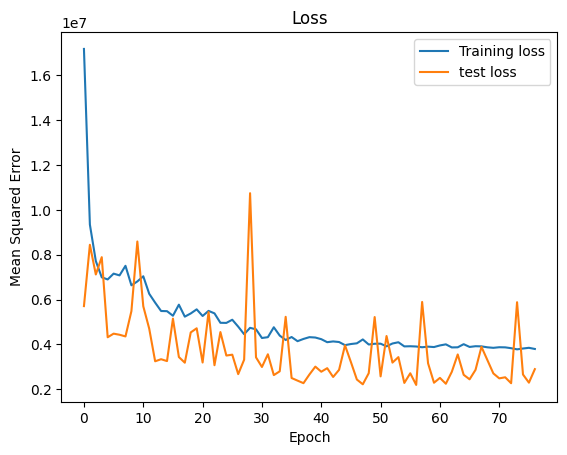

In [33]:
plot_loss(model2)

In [34]:
model2 = tf.keras.models.load_model("model2")

model2_train_rmse = model2.evaluate(X_train2, y_train2, verbose=0)[1]
model2_test_rmse = model2.evaluate(X_test2, y_test2, verbose=0)[1]

print(f"Model 2 Training RMSE: {model2_train_rmse}")
print(f"Model 2 Test RMSE: {model2_test_rmse}")

Model 2 Training RMSE: 1989.5511474609375
Model 2 Test RMSE: 1479.3258056640625


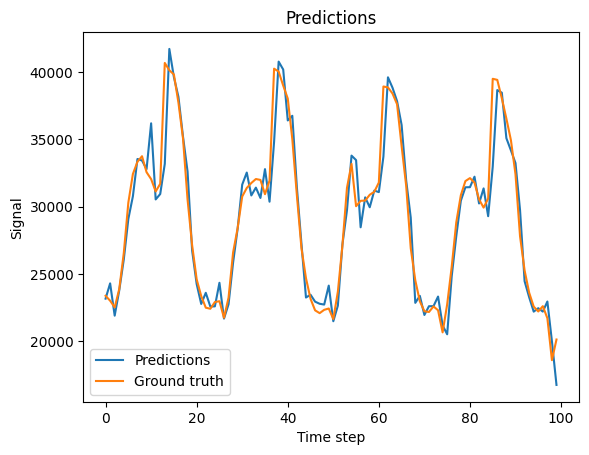

In [36]:
plot_predictions(model2, X_test2, y_test2, n_samples=100)

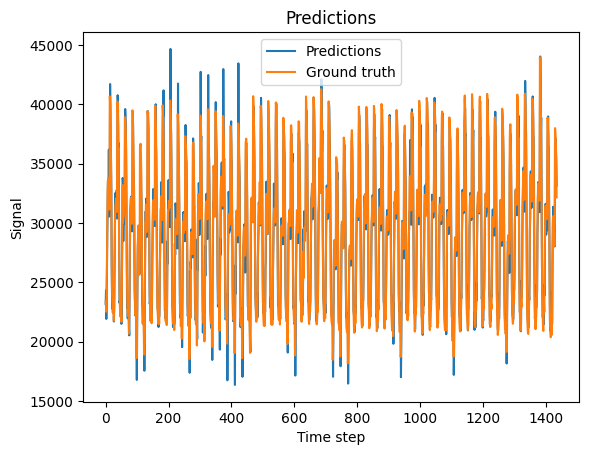

In [37]:
plot_predictions(model2, X_test2, y_test2)

Here, we can see that this multivariate forecaster model is better than the univariate forecaster model. But it still cannot well capture the sharply changed signal.

### Multivariate forecaster for PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3

#### Baseline Model

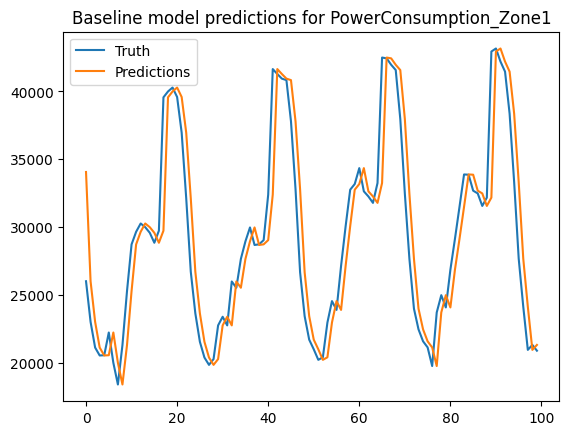

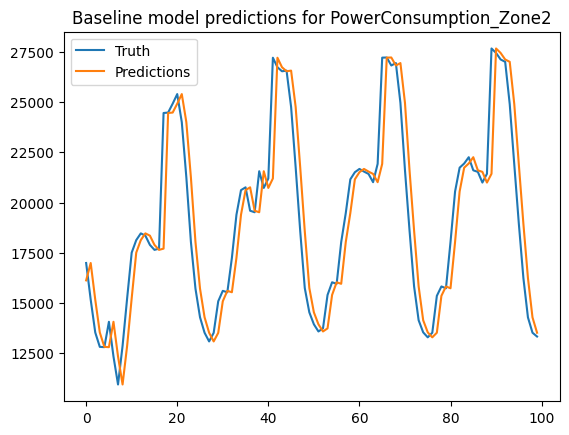

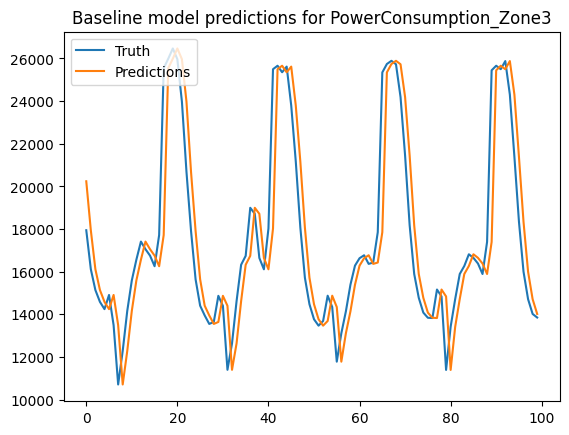

In [51]:
baseline_truth1 = df["PowerConsumption_Zone1"][1:].to_numpy()
baseline_predictions1 = df["PowerConsumption_Zone1"][:-1].to_numpy()

baseline_truth2 = df["PowerConsumption_Zone2"][1:].to_numpy()
baseline_predictions2 = df["PowerConsumption_Zone2"][:-1].to_numpy()

baseline_truth3 = df["PowerConsumption_Zone3"][1:].to_numpy()
baseline_predictions3 = df["PowerConsumption_Zone3"][:-1].to_numpy()

n_samples = 100

plt.plot(baseline_truth1[:n_samples], label="Truth")
plt.plot(baseline_predictions1[:n_samples], label="Predictions")
plt.title("Baseline model predictions for PowerConsumption_Zone1")
plt.legend(loc="upper left")
plt.show()

plt.plot(baseline_truth2[:n_samples], label="Truth")
plt.plot(baseline_predictions2[:n_samples], label="Predictions")
plt.title("Baseline model predictions for PowerConsumption_Zone2")
plt.legend(loc="upper left")
plt.show()

plt.plot(baseline_truth3[:n_samples], label="Truth")
plt.plot(baseline_predictions3[:n_samples], label="Predictions")
plt.title("Baseline model predictions for PowerConsumption_Zone3")
plt.legend(loc="upper left")
plt.show()

In [52]:
# calculate RMSE (Root Mean Squared Error)

baseline_mse = np.mean(np.power(baseline_truth1 - baseline_predictions1, 2) + np.power(baseline_truth2 - baseline_predictions2, 2) + np.power(baseline_truth3 - baseline_predictions3, 2))
baseline_rmse = np.sqrt(baseline_mse)

print(f"Baseline MSE: {baseline_mse}")
print(f"Baseline RMSE: {baseline_rmse}")

Baseline MSE: 16855265.629225247
Baseline RMSE: 4105.516487511071


#### Neural network model

In [53]:
from datetime import datetime
split_date = datetime.strptime('2017-11-01','%Y-%m-%d')

train_df3 = df[df.index < split_date]
test_df3 = df[df.index >= split_date]

print(f"Train dataset: {train_df3.shape}")
print(f"Test dataset: {test_df3.shape}")

Train dataset: (7296, 8)
Test dataset: (1440, 8)


In [54]:
# Here we generate the split and test datasets based on the power consumption in three zones.
X_train3, y_train3 = generate_windows(
    df = train_df3,
    inputs = ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"],
    outputs = ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"],
    window_size = 5,
)

print(f"X_train3: {X_train3.shape}")
print(f"y_train3: {y_train3.shape}")

X_train3: (7291, 5, 3)
y_train3: (7291, 3)


In [55]:
X_test3, y_test3 = generate_windows(
    df = test_df3,
    inputs = ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"],
    outputs = ["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"],
    window_size = 5,
)

print(f"X_test3: {X_test3.shape}")
print(f"y_test3: {y_test3.shape}")

X_test3: (1435, 5, 3)
y_test3: (1435, 3)


In [56]:
model3 = tf.keras.Sequential([
    Input(shape=(5, 3)),
    Conv1D(64, 2),
    Flatten(),
    Dense(16, activation="relu"),
    Dense(3, activation="linear"),
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)

model3.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=[RootMeanSquaredError()]
)

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 64)             448       
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                4112      
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                                 
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [57]:
epochs = 100
batch_size = 32
callbacks = [
    ModelCheckpoint("model3/", save_best_only=True),
    EarlyStopping(patience=20),
]

model3.fit(
    X_train3,
    y_train3,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    validation_data=(X_test3, y_test3),
)

Epoch 1/100
227/228 [============================>.] - ETA: 0s - loss: 19704378.0000 - root_mean_squared_error: 4438.9609

228/228 [==============================] - 6s 18ms/step - loss: 19655272.0000 - root_mean_squared_error: 4433.4263 - val_loss: 6307041.5000 - val_root_mean_squared_error: 2511.3826
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 5184956.0000 - root_mean_squared_error: 2277.0496

228/228 [==============================] - 2s 9ms/step - loss: 5184956.0000 - root_mean_squared_error: 2277.0496 - val_loss: 4099483.5000 - val_root_mean_squared_error: 2024.7178
Epoch 3/100
228/228 [==============================] - 1s 3ms/step - loss: 4809703.0000 - root_mean_squared_error: 2193.1042 - val_loss: 4893713.0000 - val_root_mean_squared_error: 2212.1741
Epoch 4/100
214/228 [===========================>..] - ETA: 0s - loss: 5151683.0000 - root_mean_squared_error: 2269.7322

228/228 [==============================] - 1s 6ms/step - loss: 5142120.0000 - root_mean_squared_error: 2267.6248 - val_loss: 3450059.7500 - val_root_mean_squared_error: 1857.4333
Epoch 5/100
228/228 [==============================] - 1s 4ms/step - loss: 4967527.0000 - root_mean_squared_error: 2228.7954 - val_loss: 5586037.0000 - val_root_mean_squared_error: 2363.4797
Epoch 6/100
228/228 [==============================] - 1s 4ms/step - loss: 4515629.5000 - root_mean_squared_error: 2125.0010 - val_loss: 3839559.7500 - val_root_mean_squared_error: 1959.4796
Epoch 7/100
228/228 [==============================] - 1s 5ms/step - loss: 4703298.5000 - root_mean_squared_error: 2168.7092 - val_loss: 3478437.0000 - val_root_mean_squared_error: 1865.0568
Epoch 8/100
228/228 [==============================] - 1s 3ms/step - loss: 4874634.5000 - root_mean_squared_error: 2207.8577 - val_loss: 4113782.7500 - val_root_mean_squared_error: 2028.2461
Epoch 9/100
228/228 [==============================] - 1s

228/228 [==============================] - 2s 7ms/step - loss: 4697441.0000 - root_mean_squared_error: 2167.3584 - val_loss: 3222105.5000 - val_root_mean_squared_error: 1795.0226
Epoch 13/100
223/228 [============================>.] - ETA: 0s - loss: 4728086.5000 - root_mean_squared_error: 2174.4160

228/228 [==============================] - 1s 7ms/step - loss: 4746746.5000 - root_mean_squared_error: 2178.7024 - val_loss: 3217546.0000 - val_root_mean_squared_error: 1793.7521
Epoch 14/100
228/228 [==============================] - 1s 3ms/step - loss: 4298455.0000 - root_mean_squared_error: 2073.2722 - val_loss: 3272521.0000 - val_root_mean_squared_error: 1809.0109
Epoch 15/100
228/228 [==============================] - 1s 3ms/step - loss: 4482729.0000 - root_mean_squared_error: 2117.2456 - val_loss: 3944623.5000 - val_root_mean_squared_error: 1986.1075
Epoch 16/100
228/228 [==============================] - 1s 2ms/step - loss: 4470994.5000 - root_mean_squared_error: 2114.4719 - val_loss: 5843924.0000 - val_root_mean_squared_error: 2417.4209
Epoch 17/100
228/228 [==============================] - 1s 3ms/step - loss: 4847152.0000 - root_mean_squared_error: 2201.6250 - val_loss: 4155928.2500 - val_root_mean_squared_error: 2038.6097
Epoch 18/100
228/228 [==============================]

228/228 [==============================] - 2s 10ms/step - loss: 4710935.0000 - root_mean_squared_error: 2170.4685 - val_loss: 3197253.0000 - val_root_mean_squared_error: 1788.0864
Epoch 21/100
228/228 [==============================] - 1s 4ms/step - loss: 4585838.5000 - root_mean_squared_error: 2141.4565 - val_loss: 4202463.0000 - val_root_mean_squared_error: 2049.9912
Epoch 22/100
228/228 [==============================] - 1s 3ms/step - loss: 4428675.0000 - root_mean_squared_error: 2104.4414 - val_loss: 3974932.5000 - val_root_mean_squared_error: 1993.7231
Epoch 23/100
228/228 [==============================] - 1s 3ms/step - loss: 4339383.0000 - root_mean_squared_error: 2083.1184 - val_loss: 4474317.5000 - val_root_mean_squared_error: 2115.2585
Epoch 24/100
228/228 [==============================] - 1s 3ms/step - loss: 4406884.5000 - root_mean_squared_error: 2099.2581 - val_loss: 3271631.7500 - val_root_mean_squared_error: 1808.7653
Epoch 25/100
228/228 [==============================

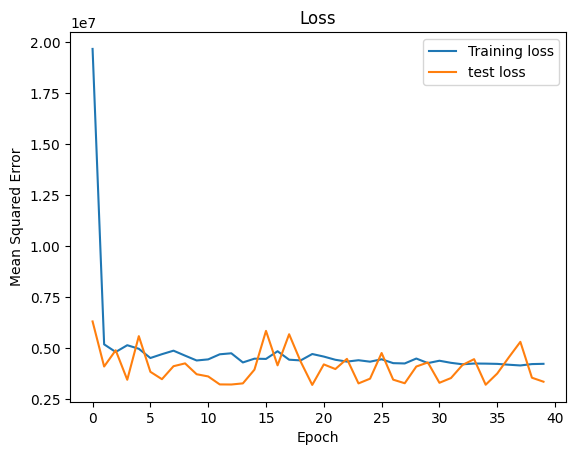

In [58]:
plot_loss(model3)

In [59]:
model3 = tf.keras.models.load_model("model3")

model3_train_rmse = model3.evaluate(X_train3, y_train3, verbose=0)[1]
model3_test_rmse = model3.evaluate(X_test3, y_test3, verbose=0)[1]

print(f"Model 3 Training RMSE: {model3_train_rmse}")
print(f"Model 3 Test RMSE: {model3_test_rmse}")

Model 3 Training RMSE: 2049.671875
Model 3 Test RMSE: 1788.08642578125


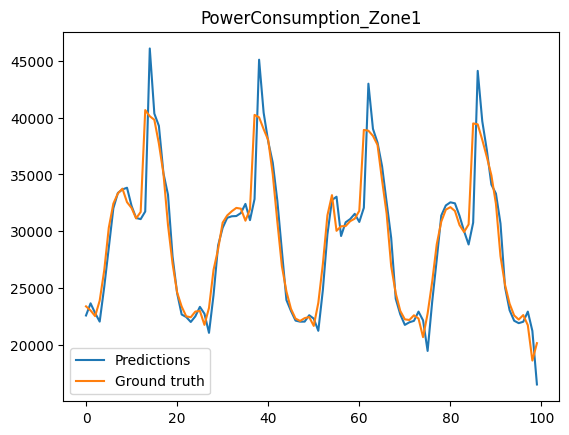

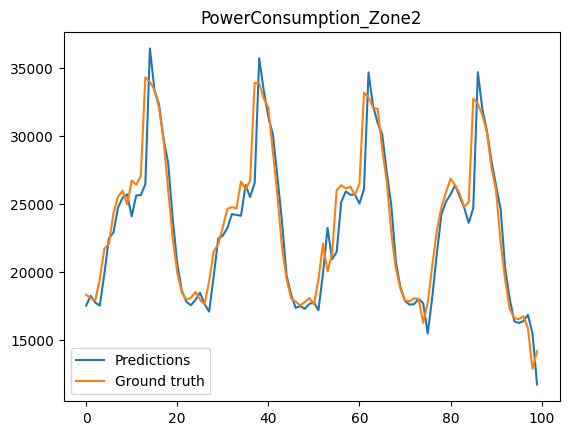

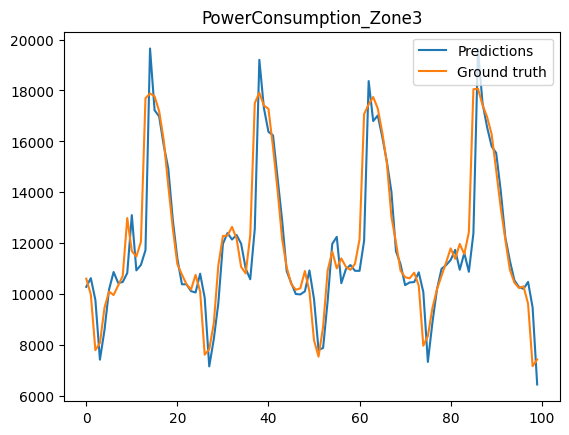

In [60]:
plot_predictions_multivariate(model3, X_test3, y_test3, n_features=3, n_samples=100, label_names=["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"])

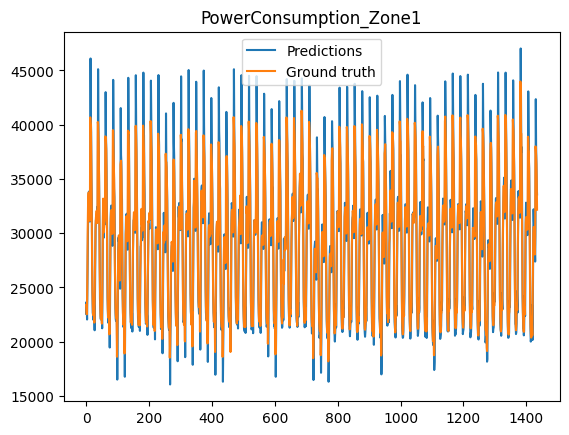

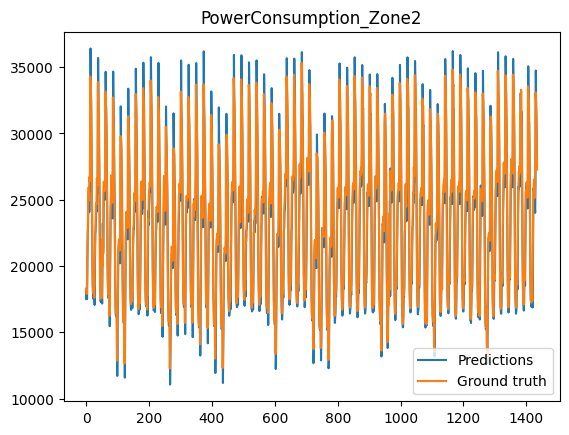

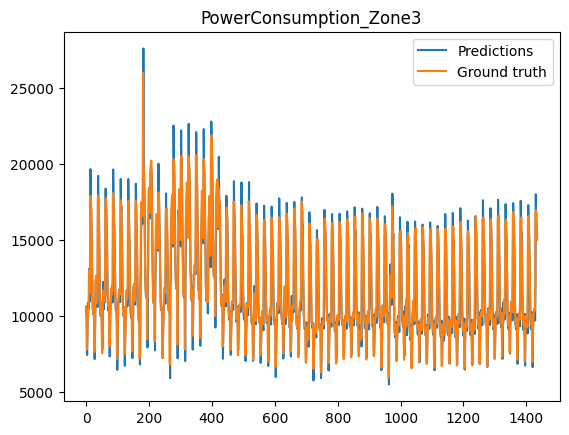

In [61]:
plot_predictions_multivariate(model3, X_test3, y_test3, n_features=3, label_names=["PowerConsumption_Zone1", "PowerConsumption_Zone2", "PowerConsumption_Zone3"])

We can see that neutral network model does a better job than baseline model. Although it still cannot perfectly capture the sharply changed signal, it can well predict the data trend. By making more efforts training this model, we can get better prediction.